Here is the data exploring for Walmart dataset from Kaggle. We will use classical models and self-attention model for weekly sales prediction.

1. Load and prepare data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


As we see, the dataset has 8 columns, and we will predict the weekly sales based on the other 7 columns. Let's get familiar with the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


There are 6435 records in the dataset without null values. Here are some more information about each column.

In [4]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


2. Feature engineering.

Because this is a time series prediction, we will separate the Date column into day, month, year, and season.

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format = '%d-%m-%Y')
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,12,2,2010
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,19,2,2010
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,26,2,2010
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,5,3,2010


We can see that new columns are already added. We will now add season feature.

In [6]:
def get_season(month):
    if month in [12, 1, 2]:
        return 3
    if month in [3, 4, 5]:
        return 0
    if month in [6, 7, 8]:
        return 1
    if month in [9, 10, 11]:
        return 2

df['Season'] = df['Month'].apply(get_season)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,Season
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010,3
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,12,2,2010,3
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,19,2,2010,3
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,26,2,2010,3
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,5,3,2010,0


In [22]:
length = int(len(df) * 0.8)
df['Weekly_Sales'][length: length+100]

5148    536006.73
5149    529852.70
5150    510382.50
5151    513615.82
5152    519255.68
          ...    
5243    527117.81
5244    537224.52
5245    533905.67
5246    605791.46
5247    451327.61
Name: Weekly_Sales, Length: 100, dtype: float64

3. Exploratory Data Analysis

3.1 Univariate Analysis.

We will see in this section how our features and labels are distributed.

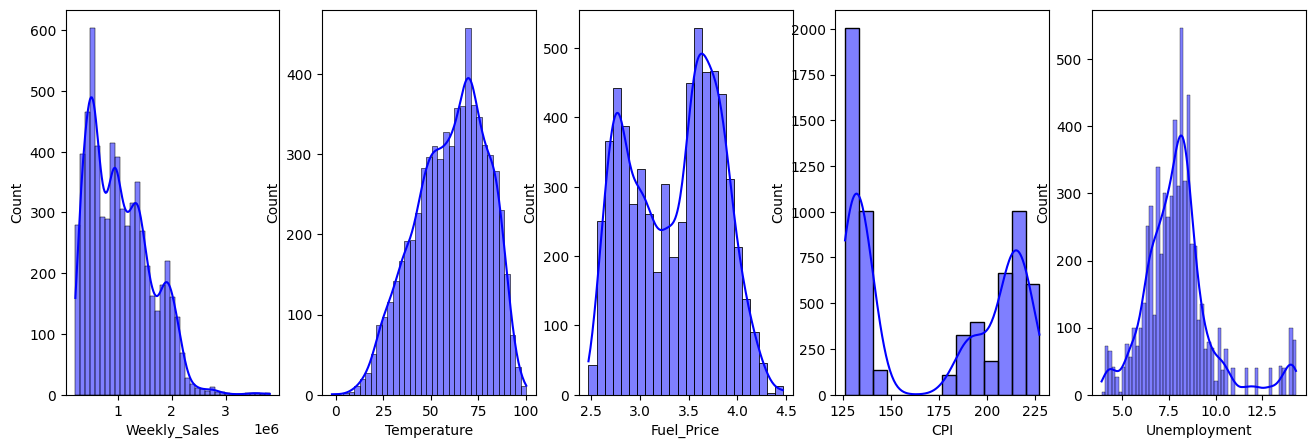

In [8]:
# Numeric features
columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
fig, ax = plt.subplots(1, 5, figsize=(16, 5))
for i, col in enumerate(columns):
    sns.histplot(
        data=df,
        x=col,
        ax=ax[i],
        kde=True,
        color = 'blue'
    )
plt.show()

We can see that
- Temperature and Unemployment feature have normal distribution.
- Fuel_Price and CPI have bimodal distribution.
- Weekly_Sales is right skewed.

Now, let's see if there are outliers for feaatures. 

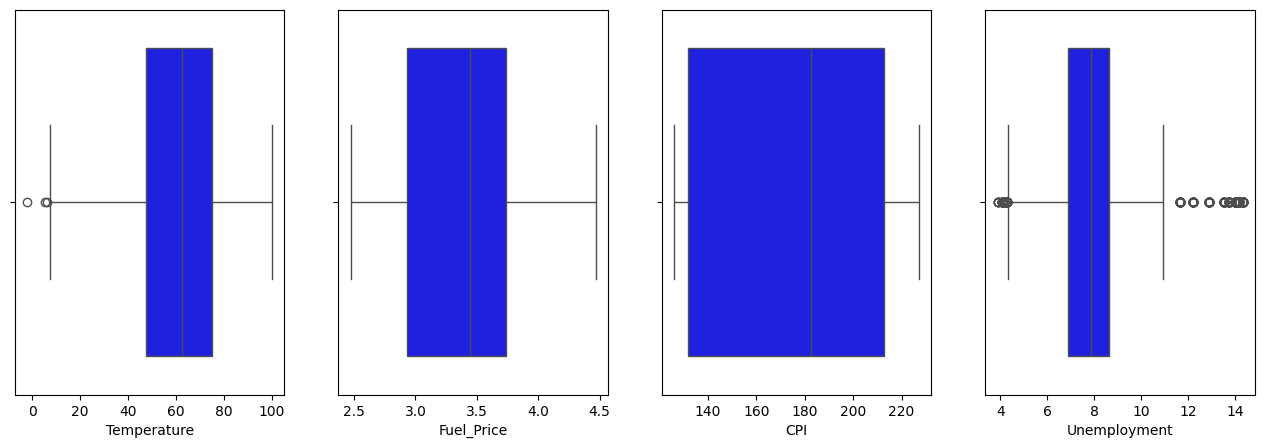

In [9]:
columns = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
fig, ax = plt.subplots(1, 4, figsize = (16,5))
for i, col in enumerate(columns):
    sns.boxplot(
        data=df,
        x = col,
        ax = ax[i],
        color = 'blue'
    )
plt.show()

As we can see, there are outliers for Temperature and Unemployment feature. Let us see how other categorical features are distributed.

In [10]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,Season
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010,3
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,12,2,2010,3
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,19,2,2010,3
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,26,2,2010,3
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,5,3,2010,0


In [11]:
print(df['Season'].value_counts())

Season
1    1800
0    1755
2    1530
3    1350
Name: count, dtype: int64


In [12]:
print(df['Year'].value_counts())
print(df['Month'].value_counts())

Year
2011    2340
2010    2160
2012    1935
Name: count, dtype: int64
Month
4     630
7     630
3     585
6     585
8     585
9     585
10    585
2     540
5     540
12    450
11    360
1     360
Name: count, dtype: int64


As we can see, there are less records in winters.

4. Bivariate analysis

In this section, we will see how each feature affects on the target variable. First, we will 

<Axes: xlabel='Season', ylabel='Weekly_Sales'>

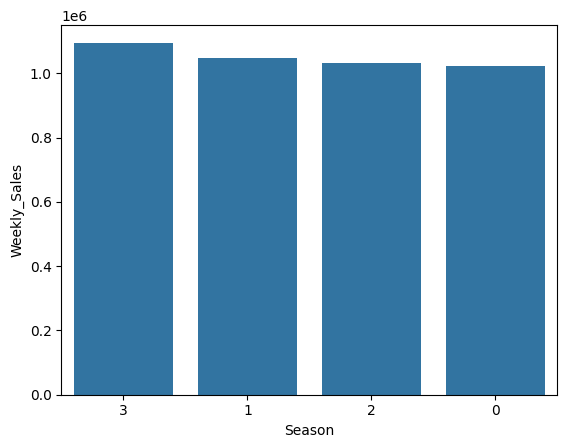

In [13]:
index_season = df.groupby('Season')['Weekly_Sales'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'Season',
    y = 'Weekly_Sales',
    order = index_season,
    errorbar = None,
    estimator=np.mean
)

<Axes: xlabel='Year', ylabel='Weekly_Sales'>

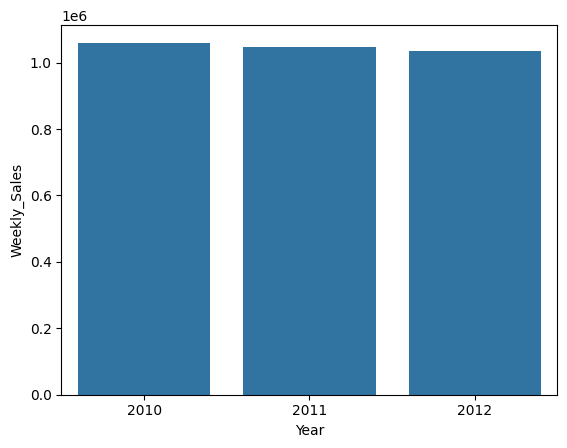

In [14]:
index_year = df.groupby('Year')['Weekly_Sales'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'Year',
    y = 'Weekly_Sales',
    order = index_year,
    errorbar = None,
    estimator=np.mean
)

<Axes: xlabel='Month', ylabel='Weekly_Sales'>

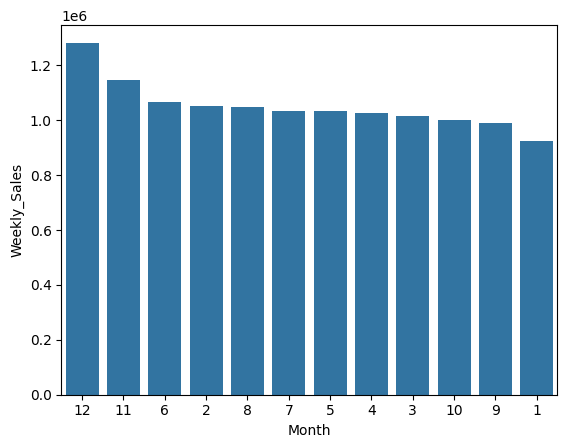

In [15]:
index_month = df.groupby('Month')['Weekly_Sales'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'Month',
    y = 'Weekly_Sales',
    order = index_month,
    errorbar = None,
    estimator=np.mean
)

We can see that the sales in December and November is high.

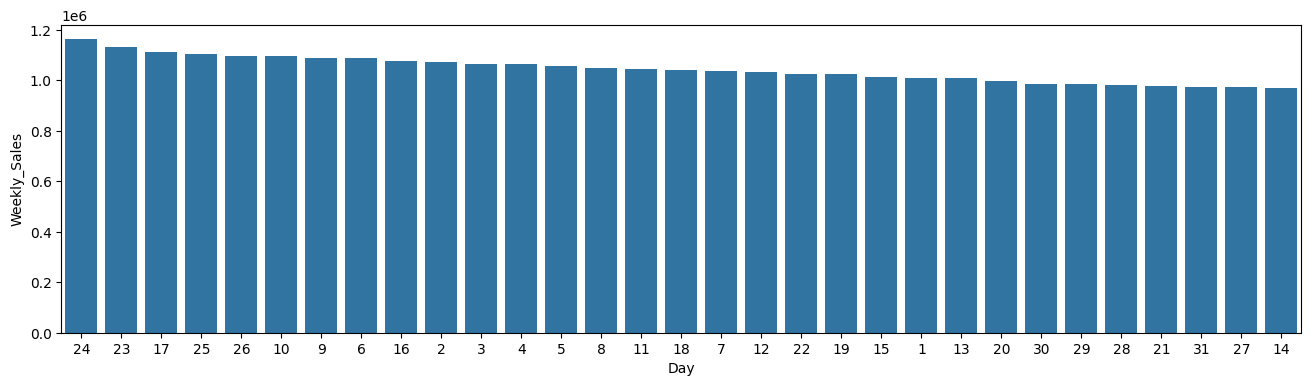

In [16]:
plt.figure(figsize = (16, 4))
index_day = df.groupby('Day')['Weekly_Sales'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'Day',
    y = 'Weekly_Sales',
    order = index_day,
    errorbar = None,
    estimator=np.mean
)
plt.show()

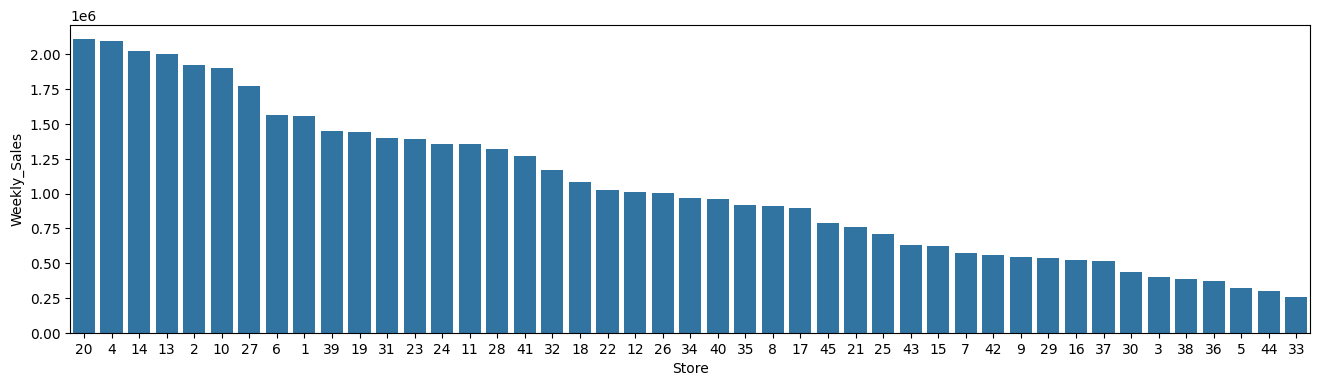

In [17]:
plt.figure(figsize=(16,4))
index_store = df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'Store',
    y = 'Weekly_Sales',
    order = index_store,
    errorbar = None,
    estimator=np.mean
)
plt.show()

As we can see, the sales depend on the store number. Next, let's see if the sales in holiday is higher than usual.

<Axes: xlabel='Holiday_Flag', ylabel='Weekly_Sales'>

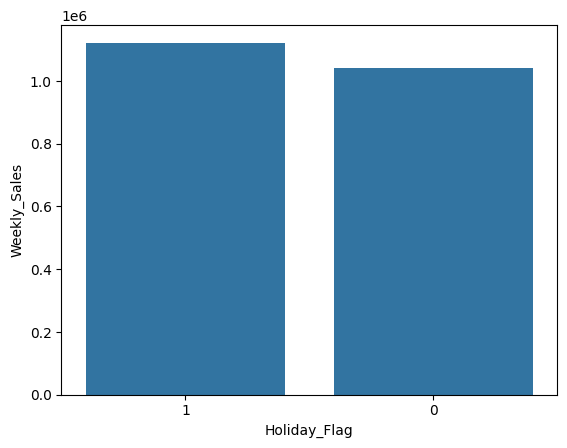

In [18]:
index_holiday = df.groupby('Holiday_Flag')['Weekly_Sales'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'Holiday_Flag',
    y = 'Weekly_Sales',
    order = index_holiday,
    errorbar = None,
    estimator=np.mean
)

Now, let's move to continuous features. They are Temperature, Fuel_Price, CPI and Unemployment.